In [1]:
import json
import os
from concurrent.futures import ThreadPoolExecutor, as_completed
from azure.ai.projects import AIProjectClient
from azure.identity import DefaultAzureCredential
from azure.ai.agents.models import ListSortOrder
from time import sleep
from datetime import datetime
import pandas as pd
from IPython.display import display, clear_output
import threading
import datetime

# Azure-Projekt initialisieren
project = AIProjectClient(
    credential=DefaultAzureCredential(),
    endpoint="https://master-thesis-resource.services.ai.azure.com/api/projects/master-thesis"
)

agent = project.agents.get_agent("asst_qoZLrkIiUYwFmEDtmA2wUM5q")

# Tasks laden
with open("thesis.tasks.json", "r", encoding="utf-8") as f:
    tasks = json.load(f)

output_dir = "agent_outputs"
os.makedirs(output_dir, exist_ok=True)

# Eingabetext generieren
def format_task_prompt(task):
    products = "\n".join([f"- SKU: {p['sku']}, Menge: {p['quantity']}" for p in task["products"]])
    return (
        f"Task ID: {task['taskId']}\n"
        f"Kunde: {task['customerName']} ({task['customerId']})\n"
        f"Zeitraum: {task['startDate']} bis {task['endDate']}\n"
        f"Status: {task['status']}\n"
        f"Achtung: {'Ja' if task['hasWarning'] else 'Nein'}\n"
        f"Produkte:\n{products}"
    )

# Fortschrittstabelle initialisieren
progress_lock = threading.Lock()
progress_df = pd.DataFrame(columns=["Task", "Run", "Status", "Dauer (s)"])

def update_progress(task_id, run_index, status, duration=None):
    global progress_df
    with progress_lock:
        idx = (progress_df["Task"] == task_id) & (progress_df["Run"] == run_index)
        if idx.any():
            if duration is not None:
                progress_df.loc[idx, "Dauer (s)"] = duration
            progress_df.loc[idx, "Status"] = status
        else:
            progress_df.loc[len(progress_df)] = [task_id, run_index, status, duration]
        clear_output(wait=True)
        display(progress_df.sort_values(by=["Task", "Run"]))

# Einzelner Agenten-Run
def run_agent_for_task(task, run_index):
    task_id = task["taskId"]
    user_input = format_task_prompt(task)
    thread = project.agents.threads.create()
    project.agents.messages.create(thread_id=thread.id, role="user", content=user_input)

    retry_count = 0
    max_retries = 5
    wait_seconds = 15
    while True:
        run = project.agents.runs.create_and_process(thread_id=thread.id, agent_id=agent.id)
        update_progress(task_id, run_index + 1, "running")
        while run.status not in ["completed", "failed", "cancelled"]:
            sleep(1)
            run = project.agents.runs.get(thread_id=thread.id, run_id=run.id)
        # Prüfe auf Rate Limit Fehler
        if run.status == "failed" and hasattr(run, "last_error") and run.last_error:
            error_data = getattr(run.last_error, "_data", {})
            if isinstance(error_data, dict) and error_data.get("code") == "rate_limit_exceeded":
                retry_count += 1
                if retry_count > max_retries:
                    print(f"Task {task_id}, Run {run_index+1}: Maximale Anzahl an Rate Limit Retries erreicht.")
                    break
                print(f"Task {task_id}, Run {run_index+1}: Rate Limit erreicht, warte {wait_seconds} Sekunden und versuche erneut...")
                sleep(wait_seconds)
                continue
        break

    created_at = getattr(run, "created_at", None)
    completed_at = getattr(run, "completed_at", None)
    duration = (completed_at - created_at).total_seconds() if created_at and completed_at else None

    update_progress(task_id, run_index + 1, run.status, duration)

    result = {
        "run_index": run_index + 1,
        "status": run.status,
        "duration_seconds": duration,
        "run_id": run.id,
        "model": run.model,
        "temperature": run.temperature,
        "top_p": run.top_p,
        "tools": [
            {
                "name": t.connected_agent.name,
                "id": t.connected_agent.id
            } for t in run.tools if t.type == "connected_agent"
        ],
        "usage": {
            "prompt_tokens": getattr(run.usage, "prompt_tokens", None),
            "completion_tokens": getattr(run.usage, "completion_tokens", None),
            "total_tokens": getattr(run.usage, "total_tokens", None)
        } if hasattr(run, "usage") else None,
    }

    if run.status == "failed":
        result["error"] = getattr(run, "last_error", None)
    else:
        messages = project.agents.messages.list(thread_id=thread.id, order=ListSortOrder.ASCENDING)
        result["messages"] = [
            {
                "role": m.role,
                "text": m.text_messages[-1].text.value if m.text_messages else ""
            }
            for m in messages
        ]

    return task_id, result

def get_existing_runs(output_dir, task_id):
    file_path = os.path.join(output_dir, f"{task_id}.json")
    if not os.path.exists(file_path):
        return 0
    try:
        with open(file_path, "r", encoding="utf-8") as f:
            data = json.load(f)
            if isinstance(data, list):
                return len(data)
            return 0
    except Exception as e:
        print(f"Warnung: Datei {file_path} konnte nicht gelesen werden: {e}")
        return 0

def default_serializer(obj):
    if isinstance(obj, (datetime.datetime, datetime.date)):
        return obj.isoformat()
    if hasattr(obj, "__dict__"):
        return obj.__dict__
    return str(obj)

# Parallele Ausführung
max_workers = 2
futures = []
results_per_task = {}

with ThreadPoolExecutor(max_workers=max_workers) as executor:
    for task in tasks:
        task_id = task["taskId"]
        existing_runs = get_existing_runs(output_dir, task_id)
        if existing_runs >= 3:
            print(f"Task {task_id}: Bereits 3 Runs vorhanden, überspringe.")
            continue
        print(f"Task {task_id}: {existing_runs} Runs vorhanden, führe {3-existing_runs} Runs aus.")
        results_per_task[task_id] = []
        for i in range(existing_runs, 3):
            futures.append(executor.submit(run_agent_for_task, task, i))

    for future in as_completed(futures):
        task_id, result = future.result()
        if task_id not in results_per_task:
            results_per_task[task_id] = []
        results_per_task[task_id].append(result)

# Ergebnisse speichern
for task_id, results in results_per_task.items():
    file_path = os.path.join(output_dir, f"{task_id}.json")
    if os.path.exists(file_path):
        try:
            with open(file_path, "r", encoding="utf-8") as f:
                existing = json.load(f)
                if not isinstance(existing, list):
                    existing = []
        except Exception:
            existing = []
    else:
        existing = []
    all_results = existing + results
    all_results = all_results[:3]
    with open(file_path, "w", encoding="utf-8") as f:
        json.dump(all_results, f, indent=2, ensure_ascii=False, default=default_serializer)
    print(f"Ergebnisse für Task {task_id} gespeichert in {file_path}")



Ergebnisse für Task B8R2ADZ3 gespeichert in agent_outputs\B8R2ADZ3.json
Ergebnisse für Task PAG708GD gespeichert in agent_outputs\PAG708GD.json
Ergebnisse für Task LMJUM34X gespeichert in agent_outputs\LMJUM34X.json
Ergebnisse für Task 6BWWUU5R gespeichert in agent_outputs\6BWWUU5R.json
Ergebnisse für Task 7OGVABH3 gespeichert in agent_outputs\7OGVABH3.json
Ergebnisse für Task XKSLOOYM gespeichert in agent_outputs\XKSLOOYM.json
Ergebnisse für Task N01E3NYZ gespeichert in agent_outputs\N01E3NYZ.json
Ergebnisse für Task MRPFEMMQ gespeichert in agent_outputs\MRPFEMMQ.json
Ergebnisse für Task 3ONGIKOO gespeichert in agent_outputs\3ONGIKOO.json
Ergebnisse für Task E7SCGOI9 gespeichert in agent_outputs\E7SCGOI9.json
Ergebnisse für Task 03263AMP gespeichert in agent_outputs\03263AMP.json
Ergebnisse für Task 6XXY99TV gespeichert in agent_outputs\6XXY99TV.json


In [41]:
#here sum up
import os
import pandas as pd
import json

# Verzeichnis mit den Agent-Output-Dateien
output_dir = "agent_outputs"

# Alle JSON-Dateien im Verzeichnis auflisten
files = [f for f in os.listdir(output_dir) if f.endswith('.json')]

# Alle Daten in eine Liste laden
records = []
for file in files:
    with open(os.path.join(output_dir, file), "r", encoding="utf-8") as f:
        try:
            content = json.load(f)
            # Jede Datei enthält eine Liste von Runs
            for run in content:
                run["task_id"] = os.path.splitext(file)[0]  # Task-ID aus Dateinamen
                records.append(run)
        except Exception as e:
            print(f"Fehler beim Laden von {file}: {e}")

# DataFrame erstellen
runs_df = pd.DataFrame(records)

# usage flatten
if 'usage' in runs_df.columns:
    usage_df = pd.json_normalize(runs_df['usage'])
    usage_df.columns = [f'usage.{col}' for col in usage_df.columns]
    runs_df = pd.concat([runs_df.drop(columns=['usage']), usage_df], axis=1)

# Zeilen mit Status "failed" herausfiltern
if "status" in runs_df.columns:
    runs_df = runs_df[runs_df["status"] != "failed"]

# Ergebnis anzeigen
runs_df.head()




,run_index,status,duration_seconds,run_id,model,temperature,top_p,tools,messages,task_id,error,usage.prompt_tokens,usage.completion_tokens,usage.total_tokens
0,1,completed,15.0,run_uoVhQacSrMICD0PMuOlnYAKc,gpt-4o-mini,0.01,1.0,"[{'name': 'handbook_agent', 'id': 'asst_x2t0Tt...","[{'role': 'user', 'text': 'Task ID: 03263AMP K...",03263AMP,NaN,4288,476,4764
8,1,completed,20.0,run_pcljIbtVUuehd2YCKvW6res4,gpt-4o-mini,0.01,1.0,"[{'name': 'handbook_agent', 'id': 'asst_x2t0Tt...","[{'role': 'user', 'text': 'Task ID: 6BWWUU5R K...",6BWWUU5R,NaN,4184,405,4589
10,1,completed,31.0,run_0zt4IrbZUKpRzteoH3zPMpDK,gpt-4o-mini,0.01,1.0,"[{'name': 'handbook_agent', 'id': 'asst_x2t0Tt...","[{'role': 'user', 'text': 'Task ID: 6XXY99TV K...",6XXY99TV,NaN,4388,509,4897
11,3,completed,22.0,run_GkTnakauH83cwysFbs3K9OKr,gpt-4o-mini,0.01,1.0,"[{'name': 'handbook_agent', 'id': 'asst_x2t0Tt...","[{'role': 'user', 'text': 'Task ID: 6XXY99TV K...",6XXY99TV,NaN,4349,522,4871
12,1,completed,17.0,run_gTqYBe8kztAeaXUmshwsvq1V,gpt-4o-mini,0.01,1.0,"[{'name': 'handbook_agent', 'id': 'asst_x2t0Tt...","[{'role': 'user', 'text': 'Task ID: 7OGVABH3 K...",7OGVABH3,NaN,4274,453,4727


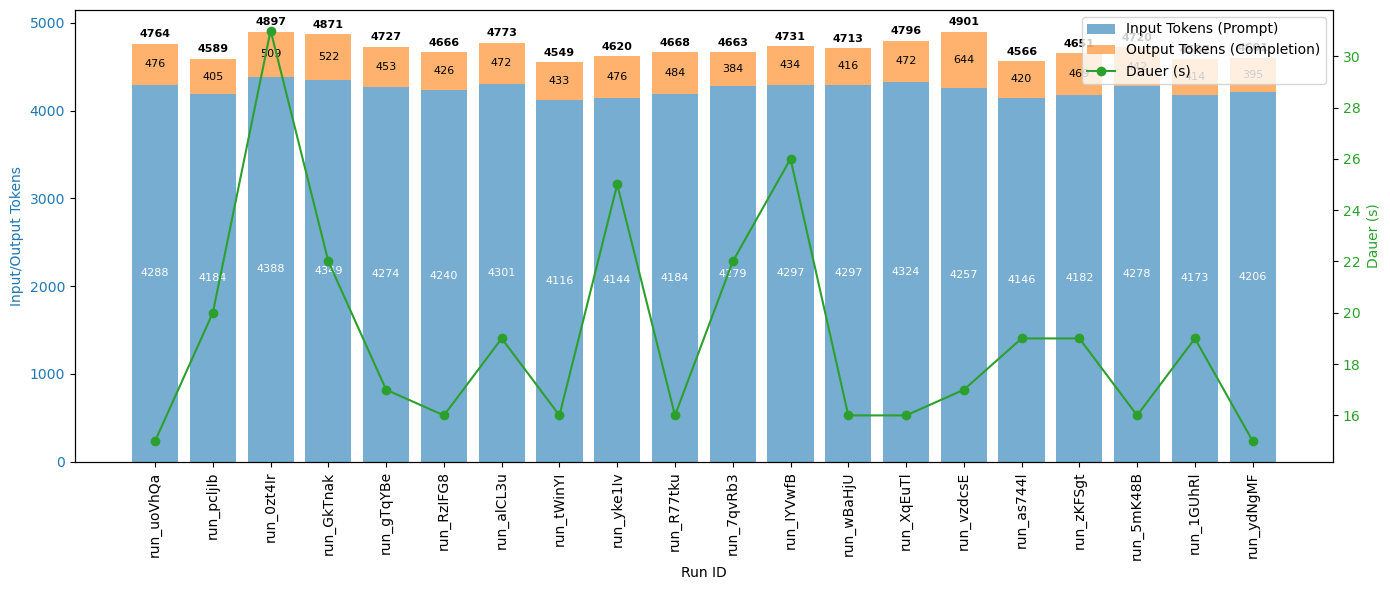

In [55]:
#here visualize
import matplotlib.pyplot as plt

# Nur erfolgreiche Runs visualisieren
plot_df = runs_df[runs_df["status"] == "completed"].copy()
if not plot_df.empty and all(col in plot_df.columns for col in ["usage.prompt_tokens", "usage.completion_tokens", "duration_seconds", "run_id"]):
    fig, ax1 = plt.subplots(figsize=(14, 6))

    color1 = 'tab:blue'
    color2 = 'tab:orange'
    color3 = 'tab:green'

    x = range(len(plot_df))
    ax1.set_xlabel('Run ID')
    ax1.set_ylabel('Input/Output Tokens', color=color1)
    ax1.bar(x, plot_df['usage.prompt_tokens'], color=color1, alpha=0.6, label='Input Tokens (Prompt)')
    ax1.bar(x, plot_df['usage.completion_tokens'], bottom=plot_df['usage.prompt_tokens'], color=color2, alpha=0.6, label='Output Tokens (Completion)')
    # Werte für Input, Output und Summe anzeigen
    for i, (p, c) in enumerate(zip(plot_df['usage.prompt_tokens'], plot_df['usage.completion_tokens'])):
        ax1.text(i, p/2, f'{int(p)}', ha='center', va='center', color='white', fontsize=8)
        ax1.text(i, p + c/2, f'{int(c)}', ha='center', va='center', color='black', fontsize=8)
        ax1.text(i, p + c + 50, f'{int(p + c)}', ha='center', va='bottom', color='black', fontsize=8, fontweight='bold')
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.set_xticks(x)
    ax1.set_xticklabels([rid[:10] for rid in plot_df['run_id']], rotation=90)

    ax2 = ax1.twinx()
    ax2.set_ylabel('Dauer (s)', color=color3)
    ax2.plot(x, plot_df['duration_seconds'], color=color3, marker='o', label='Dauer (s)')
    ax2.tick_params(axis='y', labelcolor=color3)

    fig.tight_layout()
    fig.legend(loc='upper right', bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
    plt.show()

In [56]:
# here data analysis
# hier genaue Auswertung
if not plot_df.empty:
    min_input = plot_df['usage.prompt_tokens'].min()
    max_input = plot_df['usage.prompt_tokens'].max()
    avg_input = plot_df['usage.prompt_tokens'].mean()
    min_output = plot_df['usage.completion_tokens'].min()
    max_output = plot_df['usage.completion_tokens'].max()
    avg_output = plot_df['usage.completion_tokens'].mean()
    min_sum = (plot_df['usage.prompt_tokens'] + plot_df['usage.completion_tokens']).min()
    max_sum = (plot_df['usage.prompt_tokens'] + plot_df['usage.completion_tokens']).max()
    avg_sum = (plot_df['usage.prompt_tokens'] + plot_df['usage.completion_tokens']).mean()
    min_duration = plot_df['duration_seconds'].min()
    max_duration = plot_df['duration_seconds'].max()
    avg_duration = plot_df['duration_seconds'].mean()
    print('--- Token- und Laufzeit-Statistiken (nur completed) ---')
    print(f'Input-Tokens:   min={min_input}, max={max_input}, avg={avg_input:.2f}')
    print(f'Output-Tokens:  min={min_output}, max={max_output}, avg={avg_output:.2f}')
    print(f'Summe-Tokens:   min={min_sum}, max={max_sum}, avg={avg_sum:.2f}')
    print(f'Dauer (s):      min={min_duration}, max={max_duration}, avg={avg_duration:.2f}')
else:
    print('Keine Daten für Auswertung vorhanden.')


--- Token- und Laufzeit-Statistiken (nur completed) ---
Input-Tokens:   min=4116, max=4388, avg=4245.35
Output-Tokens:  min=384, max=644, avg=457.30
Summe-Tokens:   min=4549, max=4901, avg=4702.65
Dauer (s):      min=15.0, max=31.0, avg=19.10


In [54]:
# DataFrame als JSON speichern
runs_df.to_json("runs_df.json", orient="records", force_ascii=False, indent=2)#here file output
